In [1]:
# pip install keras

In [2]:
# pip install tensorflow

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('model_curr.csv')
df.head()

,Date,Price
0,2014-01-01,38.21
1,2014-01-02,37.61
2,2014-01-03,37.01
3,2014-01-06,36.63
4,2014-01-07,35.41


In [5]:
df.tail()

,Date,Price
2575,2024-05-31,167.20
2576,2024-06-03,174.25
2577,2024-06-04,158.95
2578,2024-06-05,169.20
2579,2024-06-06,172.05


In [6]:
cop = df.reset_index()['Price']
cop

0        38.21
1        37.61
2        37.01
3        36.63
4        35.41
         ...  
2575    167.20
2576    174.25
2577    158.95
2578    169.20
2579    172.05
Name: Price, Length: 2580, dtype: float64

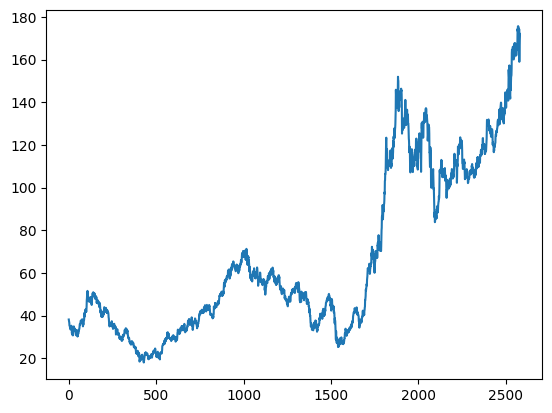

In [7]:
plt.plot(cop)

In [8]:
#!LSTM are sensitive to the scale of the data, so we apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
cop = scaler.fit_transform(np.array(cop).reshape(-1,1))

In [9]:
cop

array([[0.12792987],
       [0.12411866],
       [0.12030744],
       ...,
       [0.89487391],
       [0.95998221],
       [0.9780855 ]])

In [10]:
len(cop)

2580

In [11]:
trainingSize = int(len(cop)*0.80)
testSize = len(cop)-trainingSize

train_data, test_data = cop[0:trainingSize,:],cop[trainingSize:len(cop),:1]

In [12]:
len(train_data),len(test_data)

(2064, 516)

In [13]:
#transforming time series data into a format suitable for training and testing an LSTM model.
def create_data(data,time_step):
    X, y = [],[]
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step),0]
        b = data[i+time_step,0]
        X.append(a)
        y.append(b)

    return np.array(X), np.array(y)

In [14]:
time_step = 450
X_train, y_train = create_data(train_data,time_step)
X_test, y_test = create_data(test_data,time_step)

In [15]:
print(X_train.shape), print(X_test.shape)

(1613, 450)
(65, 450)


(None, None)

In [16]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [18]:
def buildModel(input_shape):
    input_layer = Input(shape=input_shape)
    model = LSTM(units=128,return_sequences=True)(input_layer)
    model = Dropout(0.2)(model) 
    model = LSTM(units=128,return_sequences=True)(model)
    model = Dropout(0.2)(model)
    model = LSTM(units=128,return_sequences=False)(model)#the goal is to predict a single value (the stock price for the next day)
    model = Dropout(0.2)(model)
    model = Dense(64,activation='relu')(model)
    model = Dropout(0.2)(model) #added, prevents overfitting
    model = Dense(64,activation='relu')(model) #creating 64 neurons 
    output_layer = Dense(1)(model)
    neuron = Model(inputs=input_layer,outputs=output_layer)
    neuron.compile(loss='mean_squared_error',optimizer='adam')#measure the difference between the model's predictions and the actual stock prices.
    return neuron

In [19]:
clf = buildModel((450,1))
clf.summary()
# detailed overview of the model's architecture

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 450, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 450, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 450, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 450, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 450, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 342,209 (1.31 MB)

 Trainable params: 342,209 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
hist = clf.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - loss: 0.0350 - val_loss: 0.0069
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0038 - val_loss: 0.0246
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.0027 - val_loss: 0.0067
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0021 - val_loss: 0.0156
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0016 - val_loss: 0.0168
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0018 - val_loss: 0.0043
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0018 - val_loss: 0.0091
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0021 - val_loss: 0.0459
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0018 - val_loss: 0.0050
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 0.0015 - val_loss: 0.0192
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0016 - val_loss: 0.0104
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 0.0014 - val_lo

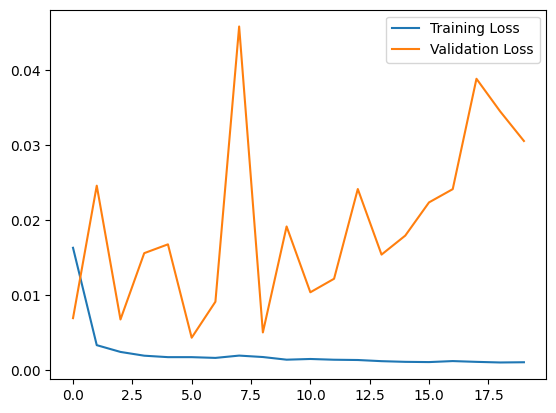

In [21]:
plt.plot(hist.history['loss'],label='Training Loss')
plt.plot(hist.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [22]:
#after trainiing model we are assigning to these variables the predictions
train_predict=clf.predict(X_train)
test_predict=clf.predict(X_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [23]:
#reversing to a original value
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [24]:
#quantifying how well our model's predictions match the actual stock prices.
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

60.46895335633531

In [25]:
math.sqrt(mean_squared_error(y_test,test_predict))

133.57230784234198

In [26]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae = mean_absolute_error(y_train,train_predict)
maep = mean_absolute_percentage_error(y_train,train_predict)
print(mae,maep)

54.259423556509944 294.3055992246515


In [27]:
#Calculating the MAE and MAPE for our model's predictions on the test data to see how well it generalizes to unseen data.
mae_pred = mean_absolute_error(y_test,test_predict) 
maep_pred = mean_absolute_percentage_error(y_test,test_predict)
print(mae_pred,maep_pred)

133.44874386464699 146.95908231526937


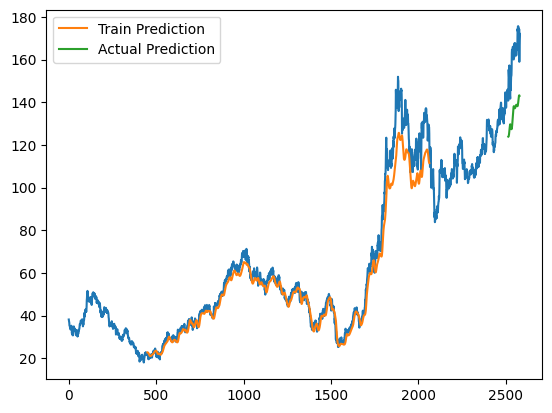

In [28]:
look_back=450
trainPredictPlot = np.empty_like(cop)#with the same shape as the original stock price data
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict ##fills with the actual training predictions 
# shift test predictions for plotting
testPredictPlot = np.empty_like(cop)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(cop)-1, :] = test_predict #Populates to the the corresponding positions.
  
# plot baseline and predictions
plt.plot(scaler.inverse_transform(cop)) #  used to convert back to their original scale
plt.plot(trainPredictPlot,label='Train Prediction')
plt.plot(testPredictPlot, label='Actual Prediction')
plt.legend()
plt.show()


In [29]:
len(test_data)

516

In [35]:
x_input = test_data[66:].reshape(1,-1)
x_input.shape

(1, 450)

In [36]:
temp_in = list(x_input)
temp_in = temp_in[0].tolist()

In [37]:
temp_in

[0.6007749475957569,
 0.6029981579114527,
 0.5998221431747442,
 0.6001397446484151,
 0.5842596709648732,
 0.5524995235977894,
 0.5686971987550021,
 0.5620275678079146,
 0.5601219589658896,
 0.567109191386648,
 0.5512291177031061,
 0.5731436193863939,
 0.5610747633869021,
 0.555357936860827,
 0.5642507781236105,
 0.5750492282284189,
 0.5686971987550021,
 0.5575811471765229,
 0.5566283427555104,
 0.5696500031760147,
 0.5696500031760147,
 0.5785428444387982,
 0.5648859810709521,
 0.5566283427555104,
 0.5401130661246267,
 0.557263545702852,
 0.5486883059137394,
 0.5432890808613351,
 0.5477355014927269,
 0.5194689703360222,
 0.5054945054945055,
 0.4899320332846344,
 0.500412881915772,
 0.5159753541256431,
 0.5099409261258971,
 0.5277266086514641,
 0.5429714793876643,
 0.5413834720193101,
 0.5407482690719685,
 0.5226449850727307,
 0.523915390967414,
 0.5210569777043765,
 0.5210569777043765,
 0.5175633614939973,
 0.5245505939147558,
 0.5207393762307057,
 0.52613860128311,
 0.5216921806517182,

In [38]:
lst_output=[]
n_steps=450
i=0
while(i<5):
    
    if(len(temp_in)>450):
        #print(temp_input)
        x_input=np.array(temp_in[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1) #generating accurate predictions 
        x_input = x_input.reshape((1, n_steps, 1)) 
        #print(x_input)
        yhat = clf.predict(x_input, verbose=0) #The verbose=0 suppresses the progress bar output.
        print("{} day output {}".format(i,yhat))
        temp_in.extend(yhat[0].tolist())
        temp_in=temp_in[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = clf.predict(x_input, verbose=0)
        print(yhat[0])
        temp_in.extend(yhat[0].tolist())
        print(len(temp_in))
        lst_output.extend(yhat.tolist())
        i=i+1 #similar to if but except it doesn't remove the first element from temp_in
    

print(lst_output)

[0.78799206]
451
1 day input [0.60299816 0.59982214 0.60013974 0.58425967 0.55249952 0.5686972
 0.56202757 0.56012196 0.56710919 0.55122912 0.57314362 0.56107476
 0.55535794 0.56425078 0.57504923 0.5686972  0.55758115 0.55662834
 0.56965    0.56965    0.57854284 0.56488598 0.55662834 0.54011307
 0.55726355 0.54868831 0.54328908 0.5477355  0.51946897 0.50549451
 0.48993203 0.50041288 0.51597535 0.50994093 0.52772661 0.54297148
 0.54138347 0.54074827 0.52264499 0.52391539 0.52105698 0.52105698
 0.51756336 0.52455059 0.52073938 0.5261386  0.52169218 0.52804421
 0.52804421 0.5471003  0.53058502 0.53026742 0.52804421 0.52836181
 0.53312583 0.55059391 0.56298037 0.55916915 0.55027631 0.5683796
 0.57568443 0.57473163 0.56202757 0.55758115 0.55535794 0.5474179
 0.55345233 0.55504034 0.55535794 0.55980436 0.55154672 0.55916915
 0.5690148  0.58870609 0.59664613 0.62110144 0.60268056 0.5915645
 0.59569332 0.58680048 0.59474052 0.5915645  0.60331576 0.5899765
 0.5906117  0.59537572 0.5899765  0.58

In [39]:
scaled_pred = scaler.inverse_transform(lst_output)
print(scaled_pred)

[[142.12359003]
 [141.25017773]
 [139.83046398]
 [137.89841729]
 [135.55412269]]


In [40]:
type(scaled_pred)

numpy.ndarray

In [41]:
newDf = pd.DataFrame(data=scaled_pred,columns=['FuturePrice'])
newDf

,FuturePrice
0,142.123590
1,141.250178
2,139.830464
3,137.898417
4,135.554123


In [42]:
newDf.to_csv('pred.csv',index=True)

In [43]:
len(cop)

2580

In [44]:
day_new=np.arange(1,451)
day_pred=np.arange(451,456)

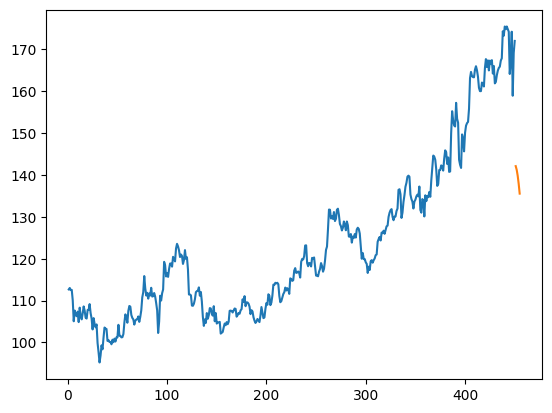

In [45]:
plt.plot(day_new,scaler.inverse_transform(cop[2130:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))